In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

ImageSize = 50
plot_name = 'plot.png'
model_name = 'mask_detector.model'

dataset_path = 'dataset'

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath,target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

data = np.array(data,dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)
aug = ImageDataGenerator(rotation_range = 20, zoom_range = 0.15, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.15, horizontal_flip = True, fill_mode = "nearest")
print(data)
print(label)

In [ ]:
baseModel = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs = headModel)
for layer in baseModel.layers:
  layer.trainable = False
print("compiling model...")
opt = Adam(learning_rate=INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("training head")
H = model.fit(aug.flow(trainX,trainY,batch_size = BS),steps_per_epoch=len(trainX)//BS , validation_data=(testX,testY),validation_steps=len(testX)//BS,epochs=EPOCHS)
print("evaluate network")
predIdxs = model.predict(testX,batch_size=BS)
predIdxs = np.argmax(predIdxs, axis = 1)

print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))
print("saving mask detector model...")
model.save(model_name)

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_name)

loading face detector model
loading face mask detector model
computing face detections...


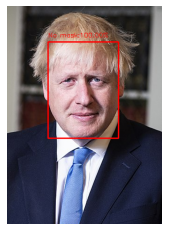

In [ ]:
#讓模型檢測照片是否有戴口罩
#需要的檔案只有
'''
deploy.prototxt
mask_detector.h5
res10_300x300_ssd_iter_140000.caffemodel
'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

def mask_detect_showimg(img_path):
  image_path = img_path
  model_path = 'mask_detector.h5'
  set_confidence = 0.5
  prototxtpath = '/content/deploy.prototxt'
  weightspath = '/content/res10_300x300_ssd_iter_140000.caffemodel'
  print("loading face detector model")
  net = cv2.dnn.readNet(prototxtpath,weightspath)

  print("loading face mask detector model")
  model = load_model(model_path)

  img = cv2.imread(image_path)
  origin_img = img.copy()
  (h,w) = img.shape[:2]

  blob = cv2.dnn.blobFromImage(img,1.0,(300,300),(104.0,177.0,123.0))
  print("computing face detections...")
  net.setInput(blob)
  detections = net.forward()

  for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence > set_confidence:
      box = detections[0,0,i,3:7] * np.array([w,h,w,h])
      (startX,startY,endX,endY) = box.astype("int")
      (startX,startY) = (max(0,startX),max(0,startY))
      (endX,endY) = (min(w-1,endX),min(h-1,endY))
      face = img[startY:endY,startX:endX]
      face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
      face = cv2.resize(face,(224,224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face,axis=0)
      (mask,withoutmask) = model.predict(face)[0]

      label = "Mask" if mask > withoutmask else "No mask"
      color = (0,255,0) if label == "Mask" else (0,0,255)
      label = "{}:{:.2f}%".format(label,max(mask,withoutmask)*100)
      cv2.putText(img, label, (startX,startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
      cv2.rectangle(img, (startX,startY), (endX,endY), color, 2)
  show_img(img)

def mask_detect(img_path):
  image_path = img_path
  model_path = 'mask_detector.h5'
  set_confidence = 0.5
  prototxtpath = '/content/deploy.prototxt'
  weightspath = '/content/res10_300x300_ssd_iter_140000.caffemodel'
  #print("loading face detector model")
  net = cv2.dnn.readNet(prototxtpath,weightspath)

  #print("loading face mask detector model")
  model = load_model(model_path)

  img = cv2.imread(image_path)
  origin_img = img.copy()
  (h,w) = img.shape[:2]

  blob = cv2.dnn.blobFromImage(img,1.0,(300,300),(104.0,177.0,123.0))
  #print("computing face detections...")
  net.setInput(blob)
  detections = net.forward()

  for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence > set_confidence:
      box = detections[0,0,i,3:7] * np.array([w,h,w,h])
      (startX,startY,endX,endY) = box.astype("int")
      (startX,startY) = (max(0,startX),max(0,startY))
      (endX,endY) = (min(w-1,endX),min(h-1,endY))
      face = img[startY:endY,startX:endX]
      face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
      face = cv2.resize(face,(224,224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face,axis=0)
      mask = 0.0
      withoutmask = 0.0
      #(mask,withoutmask) = model.predict(face)[0]
      try:
        (mask,withoutmask) = model.predict(face)[0]
        if withoutmask > mask:
          return 1
        else:
          return 0
      except:
        pass
if __name__ == '__main__':
  mask_detect_showimg('/content/330px-Boris_Johnson_official_portrait_(cropped).jpg')
  '''src_path = '/content/drive/MyDrive/台科大/專題/colab_project/9 19/dataset/without_mask/'
  num = 0
  for item in os.listdir(src_path):
    img_path = src_path + item
    try:
      value = mask_detect(img_path)
      num = num + value
    except:
      pass
  print(num)'''

In [ ]:
import os
num = 0
for item in os.listdir(src_path):
  num = num + 1
print(num)


686


In [2]:
!pip list opencv

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl